# Imports

In [1]:
import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
from clean import PCBCCleaner, DrawPointAssayCleaner, DrawPointCoordCleaner
import plotter

output_dir = "../outputs/het_analysis_wrt_time_desensitized_compare_dp_pcbc/"
SAVE = True

plt.rcParams.update(
    {
        'font.size': 18
    }
)

# %matplotlib widget

# Data Input and Cleaning

In [2]:
pcbc_df = PCBCCleaner.get_processed_data()
assay_df = DrawPointAssayCleaner.get_processed_data()

# Group and Output

## Grouping

In [3]:
ids = list(pcbc_df['dhid'].unique())
elements = [
    'CU',
    'AU'
]

### PCBC

In [4]:
pcbc_igs, pcbc_timeslices = {}, {}

for id in ids:
    dp_timeslices = {} 

    filtered_df = pcbc_df.query('dhid == @id').dropna(subset=elements).reset_index(drop=True)

    indices = filtered_df.index.to_list()

    dp_ig = {} # instantaneous grade
    for index in indices:
        date = filtered_df.iloc[index]['date']
        dp_timeslices[date] = {}
        
        for element in elements:
            if element not in dp_ig:
                dp_ig[element] = []
            
            dp_ig[element].append(filtered_df[element].loc[index])
            
            dp_timeslices[date][element] = HetAnalysis(
                f'{id}_{element}_{date}', 
                filtered_df['weight'].loc[:index], 
                filtered_df[element].loc[:index]
                )
    
    pcbc_timeslices[id] = dp_timeslices
    pcbc_igs[id] = dp_ig

### DP Assay

In [5]:
assay_igs, assay_timeslices = {}, {}

for id in ids:
    dp_timeslices = {} 

    filtered_df = assay_df.query('dhid == @id').dropna(subset=elements).reset_index(drop=True)

    indices = filtered_df.index.to_list()

    dp_ig = {} # instantaneous grade
    for index in indices:
        date = filtered_df.iloc[index]['date']
        dp_timeslices[date] = {}
        
        for element in elements:
            if element not in dp_ig:
                dp_ig[element] = []
            
            dp_ig[element].append(filtered_df[element].loc[index])
            
            dp_timeslices[date][element] = HetAnalysis(
                f'{id}_{element}_{date}', 
                filtered_df['weight'].loc[:index], 
                filtered_df[element].loc[:index]
                )
    
    assay_timeslices[id] = dp_timeslices
    assay_igs[id] = dp_ig

## Output

### Desensitized

In [6]:
stats = {}
for element in elements:
    stats[element] = {}

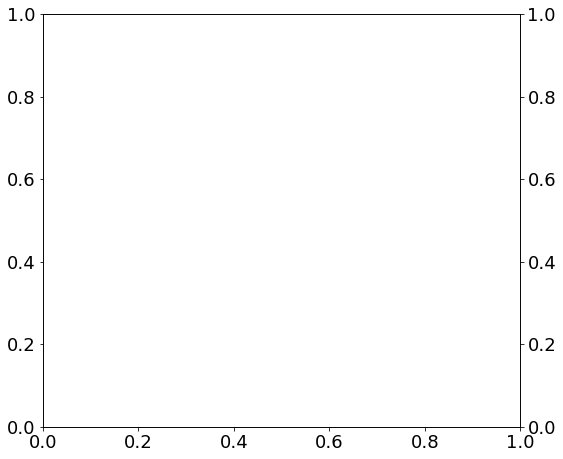

In [7]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    
    for id in ids:
        save_loc = output_dir + f'{id}/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
            
        pcbc_timeslice = pcbc_timeslices[id]
        assay_timeslice = assay_timeslices[id]
        
        for element in elements:
            pcbc_d, pcbc_h = [], []
            for date, timeslice in pcbc_timeslice.items():
                pcbc_d.append(date)
                pcbc_h.append(timeslice[element].get_heterogeneity())
                
            assay_d, assay_h = [], []
            for date, timeslice in assay_timeslice.items():
                assay_d.append(date)
                assay_h.append(timeslice[element].get_heterogeneity())
                
            fig.clear()
            ax = fig.add_subplot()
            sec_ax = ax.twinx()

            pcbc_timeslice = pcbc_timeslices[id]
            assay_timeslice = assay_timeslices[id]

            pcbc_d, pcbc_h = [], []
            for date, timeslice in pcbc_timeslice.items():
                pcbc_d.append(date)
                pcbc_h.append(timeslice[element].get_heterogeneity())
                
            assay_d, assay_h = [], []
            for date, timeslice in assay_timeslice.items():
                assay_d.append(date)
                assay_h.append(timeslice[element].get_heterogeneity())
                
            # Get a list of dates to perform interpolation on
            earliest_common_date = max(pcbc_d[0], assay_d[0])
            latest_common_date = min(pcbc_d[-1], assay_d[-1])
            dates = pcbc_d + assay_d
            dates.sort()

            common_dates = [d for d in dates if d >= earliest_common_date and d <= latest_common_date]
            if len(common_dates) == 0:
                break

            sec_ax.scatter(assay_d, assay_h, c='red', s=10)
            sec_ax.plot(assay_d, assay_h, c='red', ls='-')

            sec_ax.scatter(pcbc_d, pcbc_h, alpha=0.4, c='red', s=10)
            sec_ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='red', ls='-')

            sec_ax.set_ylim(0)
            sec_ax.set_ylabel('Heterogeneity', c='red')

            ax.set_xlim(min(min(pcbc_d), min(assay_d)), max(max(pcbc_d), min(assay_d)))
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
            ax.set_xlabel('Date')

            for label in ax.get_xticklabels(which='major'):
                label.set(rotation=45, horizontalalignment='right')

            pcbc_ig = pcbc_igs[id][element]
            assay_ig = assay_igs[id][element]

            epoch = common_dates[0]

            def to_float(d):
                return (d - epoch).total_seconds()

            delta_grades = [
                np.interp(
                    to_float(date),
                    [to_float(d) for d in assay_d], 
                    assay_ig
                ) - np.interp(
                    to_float(date),
                    [to_float(d) for d in pcbc_d], 
                    pcbc_ig
                ) for date in common_dates
            ]
            
            # TODO: weighted delta grades

            ax.scatter(common_dates, delta_grades, c='blue', s=10)
            ax.plot(common_dates, delta_grades, c='blue', ls='-')

            ax.set_ylabel(f'{element} Grade $\Delta$ (Assay - PCBC)', c='blue')

            ax.set_title(f'{id} {element} GH vs Time')

            ax.grid()
            fig.tight_layout()
        
            fig.savefig(save_loc + f'{id}_{element}.svg', format='svg')
            
            ymin, ymax = ax.get_ylim()
            bins = int((ymax - ymin) * 5)
            
            # Create histograms
            if bins > 0:
                fig.clear()
                ax = fig.add_subplot()
                
                ax.hist(delta_grades, bins=bins)

                ax.set_ylabel('Count')
                ax.set_xlabel('$\Delta$ Grade (Assay - PCBC)')

                desc_stats = pd.Series(delta_grades).describe()
                stats[element][id] = {
                    'mean': desc_stats['mean'],
                    'std': desc_stats['std'],
                    'abs_d_mean': np.mean(np.absolute(delta_grades))
                }

                ax.set_title(f'{id} $\Delta$ Grade $\mu$={desc_stats["mean"]:0.2f} $\sigma$={desc_stats["std"]:0.2f}')
                fig.tight_layout()
                fig.savefig(save_loc + f'{id}_{element}_hvg_hist.png', format='png', dpi=200)

### Visualize

In [8]:
dp_coords = DrawPointCoordCleaner.get_processed_data()

plt.rcParams.update(
    {
        'font.size': 10
    }
)

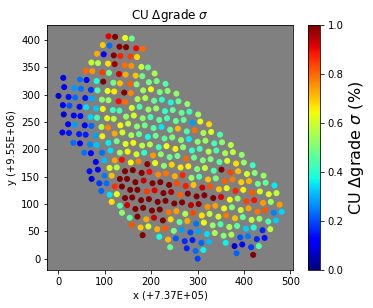

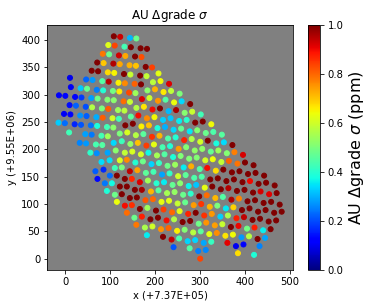

In [9]:
save_loc = output_dir + f'master/'
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
    
x_offset = np.min([dp_coords.loc[id]['x'] for id in stats[element].keys()])
y_offset = np.min([dp_coords.loc[id]['y'] for id in stats[element].keys()])

for element in elements:
    # means
    fig = plt.figure()
    fig.set_size_inches(5.5, 4.5)
    ax = fig.add_subplot()
    
    # TODO: Change this
    units = '%' if element == 'CU' else 'ppm'

    cmap = plt.colormaps.get('PiYG')
    p = ax.scatter(
        [dp_coords.loc[id]['x'] - x_offset for id in stats[element].keys()], 
        [dp_coords.loc[id]['y'] - y_offset for id in stats[element].keys()],
        c=[descriptive_stats['mean'] for descriptive_stats in stats[element].values()],
        vmax=1,
        vmin=-1,
        cmap=cmap,
        s=25,
        alpha=1 # 0.4
    )

    ax.set_facecolor('grey')
    ax.set_xlabel(f'x (+{x_offset:.2E})')
    ax.set_ylabel(f'y (+{y_offset:.2E})')
    
    ax.set_title(f'{element} $\Delta$grade $\mu$ ')

    cbar = fig.colorbar(p)
    cbar.set_label(f'{element} $\Delta$grade $\mu$ ({units})', fontsize=20)
    
    fig.savefig(save_loc + f'{element}_means.png', format='png', dpi=200)
    
    # stds
    fig.clear()
    ax = fig.add_subplot()

    cmap = plt.colormaps.get('jet')
    p = ax.scatter(
        [dp_coords.loc[id]['x'] - x_offset for id in stats[element].keys()], 
        [dp_coords.loc[id]['y'] - y_offset for id in stats[element].keys()],
        c=[descriptive_stats['std'] for descriptive_stats in stats[element].values()],
        vmax=1,
        vmin=0,
        cmap=cmap,
        s=25,
        alpha=1 # 0.4
    )

    ax.set_facecolor('grey')
    ax.set_xlabel(f'x (+{x_offset:.2E})')
    ax.set_ylabel(f'y (+{y_offset:.2E})')
    
    ax.set_title(f'{element} $\Delta$grade $\sigma$')

    cbar = fig.colorbar(p)
    cbar.set_label(f'{element} $\Delta$grade $\sigma$ ({units})', fontsize=16)
    
    fig.savefig(save_loc + f'{element}_stds.png', format='png', dpi=200)

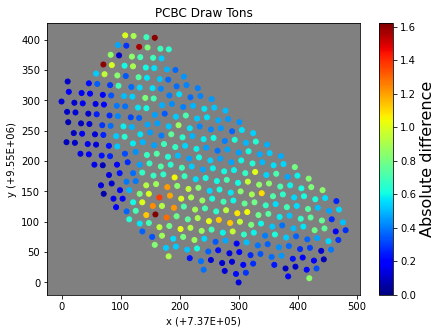

In [14]:
fig = plt.figure()
fig.set_size_inches(7, 5)
ax = fig.add_subplot()

element = 'CU'

cmap = plt.colormaps.get('jet')
p = ax.scatter(
    [dp_coords.loc[id]['x'] - x_offset for id in stats[element].keys()], 
    [dp_coords.loc[id]['y'] - y_offset for id in stats[element].keys()],
    c=[descriptive_stats['abs_d_mean'] for descriptive_stats in stats[element].values()],
    vmin=0,
    # vmax=1,
    cmap=cmap,
    s=25,
    alpha=1 # 0.4
)

ax.set_facecolor('grey')
ax.set_xlabel(f'x (+{x_offset:.2E})')
ax.set_ylabel(f'y (+{y_offset:.2E})')

ax.set_title(f'PCBC Draw Tons')

cbar = fig.colorbar(p, format='%0.1f')
cbar.set_label('Absolute difference', fontsize=16)

In [19]:
[entry['mean'] for entry in stats['CU'].values()]

[0.1852114893758204,
 0.19015773374412812,
 0.3302223523373511,
 -0.015732442676444275,
 0.07085943110119679,
 0.590387134768746,
 0.4560374265679357,
 0.08912550322369135,
 0.1380812737581124,
 0.02943888567039516,
 0.7223619850927517,
 0.4909114902955486,
 0.3443433000768522,
 -0.007846476545693207,
 -0.0518344535079428,
 0.14997730768919976,
 0.01941436181613104,
 -0.20411613681099627,
 0.032477473504340805,
 0.08346805157971583,
 0.1283952083168512,
 -0.4009377397443332,
 0.03837927079129575,
 0.04098494577815467,
 0.686548187395564,
 0.4929332633411293,
 0.6149082533970823,
 0.37018690390912556,
 0.020318795105236535,
 0.12503088285062317,
 -0.059109650377962765,
 0.1149684208496586,
 -0.1617142824421171,
 0.018926595836612447,
 0.09447563621816633,
 0.04412521367920916,
 -0.7427057317770193,
 -0.7568908201517683,
 -0.5602609776099321,
 -0.1857909658830063,
 0.5793111281683405,
 -0.19264935275380446,
 0.008280791903046623,
 -0.3041912751799821,
 -0.1616402717022991,
 -0.0651043289

In [24]:
element = 'CU'

In [32]:
stats[element].keys()

dict_keys(['P08-04W', 'P08-05W', 'P08-06W', 'P08-07W', 'P08-08W', 'P08-09W', 'P09-03W', 'P09-04E', 'P09-04W', 'P09-05E', 'P09-05W', 'P09-06E', 'P09-06W', 'P09-07E', 'P09-07W', 'P09-08E', 'P09-08W', 'P09-09E', 'P09-09W', 'P09-10W', 'P10-03E', 'P10-03W', 'P10-04E', 'P10-04W', 'P10-05E', 'P10-05W', 'P10-06E', 'P10-06W', 'P10-07E', 'P10-07W', 'P10-08E', 'P10-08W', 'P10-09E', 'P10-09W', 'P10-10E', 'P10-10W', 'P11-03E', 'P11-03W', 'P11-04E', 'P11-04W', 'P11-05E', 'P11-05W', 'P11-06E', 'P11-06W', 'P11-07E', 'P11-07W', 'P11-08E', 'P11-08W', 'P11-09E', 'P11-09W', 'P11-10E', 'P11-10W', 'P11-11W', 'P11-12W', 'P11-13W', 'P12-03E', 'P12-03W', 'P12-04E', 'P12-04W', 'P12-05E', 'P12-05W', 'P12-06E', 'P12-06W', 'P12-07E', 'P12-07W', 'P12-08E', 'P12-08W', 'P12-09E', 'P12-09W', 'P12-10E', 'P12-10W', 'P12-11E', 'P12-11W', 'P12-12E', 'P12-12W', 'P12-13E', 'P12-13W', 'P13-03E', 'P13-03W', 'P13-04E', 'P13-04W', 'P13-05E', 'P13-05W', 'P13-06E', 'P13-06W', 'P13-07E', 'P13-07W', 'P13-08E', 'P13-08W', 'P13-09E',

In [71]:
a = [ts[list(ts.keys())[-1]][element].get_cml_weight() for ts in [pcbc_timeslices[dpid] for dpid in stats[element].keys()]]
a

[37602.665069591065,
 39279.79624277608,
 42856.96708558144,
 21981.27537288336,
 21587.024898163803,
 11205.210047597444,
 103063.64538558808,
 101542.0828217214,
 96655.42929136987,
 91612.10212508691,
 97400.44075825943,
 72692.49482731849,
 108552.12771194695,
 35397.29604522305,
 98299.61970925532,
 29134.779332322418,
 59519.628120964626,
 14551.442932450096,
 59662.05438606045,
 60693.56918472983,
 95220.8534788037,
 108748.82832562982,
 114404.94569951773,
 105910.39992286601,
 110602.87693347519,
 98470.57383280655,
 113614.99763771011,
 125341.456414679,
 84088.09918070454,
 144229.11630583223,
 55843.614863614275,
 135222.00155439795,
 50782.08366489962,
 125555.67930693166,
 36962.404306333534,
 87212.80053091065,
 109510.72284442665,
 101922.64334863874,
 115368.38093677541,
 103360.21601703002,
 132394.71121717067,
 119941.00900009843,
 161571.42336780264,
 137914.78261230202,
 179447.58184453304,
 134898.4868293482,
 177178.053347685,
 132554.1934490395,
 128982.98054558

In [72]:
w = np.multiply(
    [ts[list(ts.keys())[-1]][element].get_cml_weight() for ts in [pcbc_timeslices[dpid] for dpid in stats[element].keys()]],
    [ts[list(ts.keys())[-1]][element].get_cml_weight() for ts in [assay_timeslices[dpid] for dpid in stats[element].keys()]]
)

In [79]:
np.average([entry['mean'] for entry in stats[element].values()],
           weights=w)

-0.07182885689640782

In [80]:
np.average([np.abs(entry['mean']) for entry in stats[element].values()],
           weights=w)

0.3199508029970488

## Test

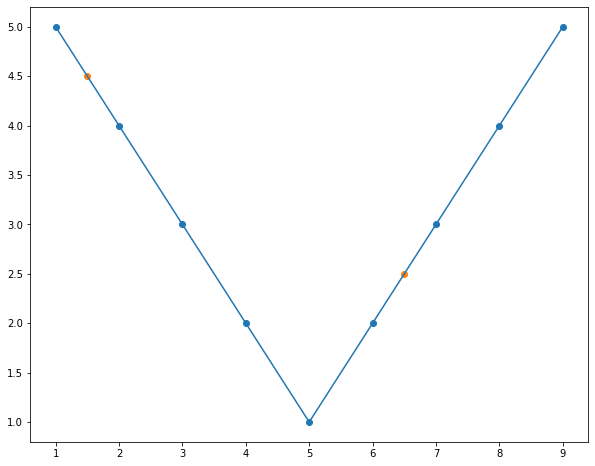

In [12]:
xs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
ys = [5, 4, 3, 2, 1, 2, 3, 4, 5]

extra_xs = [1.5, 6.5]

fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot()

ax.plot(xs, ys)
ax.scatter(xs, ys)
ax.scatter(extra_xs, [np.interp(x, xs, ys) for x in extra_xs])

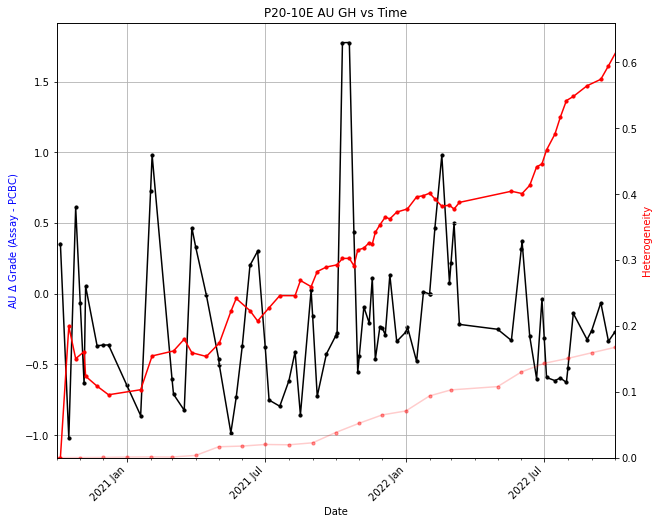

In [13]:
element = 'AU'
id = 'P20-10E'

fig = plt.figure()
fig.set_size_inches(10, 8)

fig.clear()
ax = fig.add_subplot()
sec_ax = ax.twinx()

pcbc_timeslice = pcbc_timeslices[id]
assay_timeslice = assay_timeslices[id]

pcbc_d, pcbc_h = [], []
for date, timeslice in pcbc_timeslice.items():
    pcbc_d.append(date)
    pcbc_h.append(timeslice[element].get_heterogeneity())
    
assay_d, assay_h = [], []
for date, timeslice in assay_timeslice.items():
    assay_d.append(date)
    assay_h.append(timeslice[element].get_heterogeneity())
    
# Get a list of dates to perform interpolation on
earliest_common_date = max(pcbc_d[0], assay_d[0])
latest_common_date = min(pcbc_d[-1], assay_d[-1])
dates = pcbc_d + assay_d
dates.sort()

common_dates = [d for d in dates if d >= earliest_common_date and d <= latest_common_date]

sec_ax.scatter(assay_d, assay_h, c='red', s=10)
sec_ax.plot(assay_d, assay_h, c='red', ls='-')

sec_ax.scatter(pcbc_d, pcbc_h, alpha=0.4, c='red', s=10)
sec_ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='red', ls='-')

sec_ax.set_ylim(0)
sec_ax.set_ylabel('Heterogeneity', c='red')

ax.set_xlim(min(min(pcbc_d), min(assay_d)), max(max(pcbc_d), min(assay_d)))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
ax.set_xlabel('Date')

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')

pcbc_ig = pcbc_igs[id][element]
assay_ig = assay_igs[id][element]

epoch = common_dates[0]

def to_float(d):
    return (d - epoch).total_seconds()

delta_grades = [
    np.interp(
        to_float(date),
        [to_float(d) for d in assay_d], 
        assay_ig
    ) - np.interp(
        to_float(date),
        [to_float(d) for d in pcbc_d], 
        pcbc_ig
    ) for date in common_dates
]

ax.scatter(common_dates, delta_grades, c='black', s=10)
ax.plot(common_dates, delta_grades, c='black', ls='-')

# ax.scatter(assay_d, assay_ig, c='blue', s=10)
# ax.plot(assay_d, assay_ig, c='blue', ls='-')

# ax.scatter(pcbc_d, pcbc_ig, alpha=0.4, c='blue', s=10)
# ax.plot(pcbc_d, pcbc_ig, alpha=0.2, c='blue', ls='-')

ax.set_ylabel(f'{element} $\Delta$ Grade (Assay - PCBC)', c='blue')

ax.set_title(f'{id} {element} GH vs Time')

ax.grid()


In [14]:
epoch = common_dates[0]
[np.interp(to_float(d), 
    [(d - epoch).total_seconds() for d in pcbc_d], 
    pcbc_ig) for d in common_dates
 ]

[1.8756271062358734,
 1.8891921466396702,
 1.9002908160609584,
 1.9076899290084839,
 1.914614160855611,
 1.917383853594462,
 1.938156549135844,
 1.9492353200912476,
 1.9625770430411063,
 2.0083200931549072,
 2.041742286374492,
 2.065880537033081,
 2.060383234705244,
 1.9889183044433594,
 1.9708250722577494,
 1.8441724469584804,
 1.7537062860304309,
 1.7084732055664062,
 1.5412998755772909,
 1.3502446413040161,
 1.3573297339100991,
 1.4636061230013446,
 1.513201771243926,
 1.5698825120925903,
 1.529872973759969,
 1.489863435427348,
 1.4498538970947266,
 1.4619160698306175,
 1.4956901534911125,
 1.524639368057251,
 1.46136095446925,
 1.4059923425797494,
 1.2952551188007477,
 1.2794355154037476,
 1.2549456357955933,
 1.2059658765792847,
 1.156986117362976,
 1.147788320818255,
 1.1155960329117314,
 1.0742059484604867,
 1.0466125588263235,
 1.0236180674645208,
 1.0144202709197998,
 0.9743103146553039,
 0.9275153656800588,
 0.9007753948370616,
 0.8740354239940643,
 0.8339254677295684,
 0.813

In [15]:
ymin, ymax = ax.get_ylim()
bins = int((ymax - ymin) * 5)
bins

15

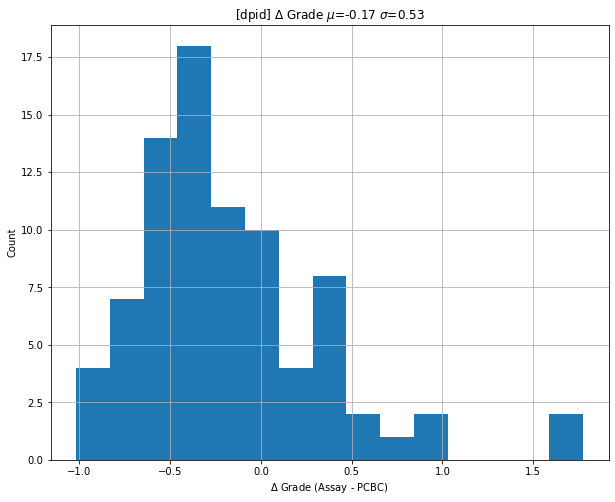

In [16]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot()

ax.hist(delta_grades, bins=bins)

ax.set_ylabel('Count')
ax.set_xlabel('$\Delta$ Grade (Assay - PCBC)')

desc_stats = pd.Series(delta_grades).describe()

ax.set_title(f'[dpid] $\Delta$ Grade $\mu$={desc_stats["mean"]:0.2f} $\sigma$={desc_stats["std"]:0.2f}')
ax.grid()

# from scipy.stats import norm
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, desc_stats["mean"], desc_stats["std"])
  
# plt.plot(x, p, 'k', linewidth=2)

In [17]:
pd.Series(delta_grades).describe()

count    83.000000
mean     -0.172046
std       0.526752
min      -1.019192
25%      -0.515325
50%      -0.277788
75%       0.038681
max       1.775794
dtype: float64

In [18]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from dateutil import rrule

def filter_by_date(df, date):
    return df[(df['date'] >= date) & (df['date'] < (date + relativedelta(months=1)))]

In [19]:
# Find the months in the datasets
earliest = min(common_dates)
latest = max(common_dates)

datetime.date(earliest)
for dt in rrule.rrule(rrule.MONTHLY, dtstart=earliest, until=latest):
    print(datetime(dt.year, dt.month, day=1))

2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00
2021-06-01 00:00:00
2021-07-01 00:00:00
2021-08-01 00:00:00
2021-09-01 00:00:00
2021-10-01 00:00:00
2021-11-01 00:00:00
2021-12-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00


In [20]:
elements = [
    'CU',
    'AU'
]

def group_by_month(df):
    return_dict = {}
    
    earliest = df['date'].dt.date.min()
    latest = df['date'].dt.date.max()
    for dt in rrule.rrule(rrule.MONTHLY, dtstart=earliest, until=latest):
        filtered_df = filter_by_date(df, datetime(dt.year, dt.month, day=1))
        
        return_dict[dt] = {}
        date = f'{dt.year}_{dt.month}'
        for element in elements:
            try:
                return_dict[dt][element] = HetAnalysis(f'{date}_{element}', filtered_df['weight'], filtered_df[element])
            except:
                print(f'Invalid data for {date}_{element}')
                
    return return_dict

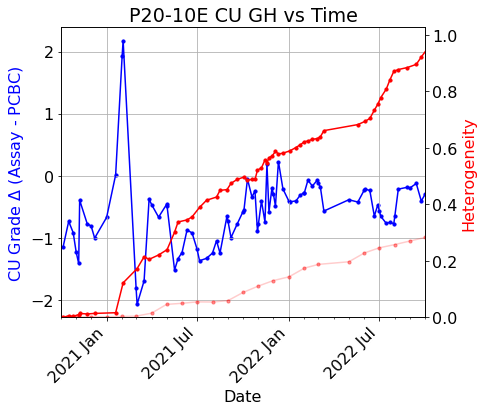

In [22]:
fig = plt.figure()
fig.set_size_inches(7, 6)

plt.rcParams.update(
    {
        'font.size': 16
    }
)
id = 'P20-10E'
pcbc_timeslice = pcbc_timeslices[id]
assay_timeslice = assay_timeslices[id]
element = 'CU'

pcbc_d, pcbc_h = [], []
for date, timeslice in pcbc_timeslice.items():
    pcbc_d.append(date)
    pcbc_h.append(timeslice[element].get_heterogeneity())
    
assay_d, assay_h = [], []
for date, timeslice in assay_timeslice.items():
    assay_d.append(date)
    assay_h.append(timeslice[element].get_heterogeneity())
            
fig.clear()
ax = fig.add_subplot()
sec_ax = ax.twinx()

# Get a list of dates to perform interpolation on
earliest_common_date = max(pcbc_d[0], assay_d[0])
latest_common_date = min(pcbc_d[-1], assay_d[-1])
dates = pcbc_d + assay_d
dates.sort()

common_dates = [d for d in dates if d >= earliest_common_date and d <= latest_common_date]
if len(common_dates) > 0:
    sec_ax.scatter(assay_d, assay_h, c='red', s=10)
    sec_ax.plot(assay_d, assay_h, c='red', ls='-')

    sec_ax.scatter(pcbc_d, pcbc_h, alpha=0.4, c='red', s=10)
    sec_ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='red', ls='-')

    sec_ax.set_ylim(0)
    sec_ax.set_ylabel('Heterogeneity', c='red')

    ax.set_xlim(min(min(pcbc_d), min(assay_d)), max(max(pcbc_d), min(assay_d)))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
    ax.set_xlabel('Date')

    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=45, horizontalalignment='right')

    pcbc_ig = pcbc_igs[id][element]
    assay_ig = assay_igs[id][element]

    epoch = common_dates[0]

    def to_float(d):
        return (d - epoch).total_seconds()

    delta_grades = [
        np.interp(
            to_float(date),
            [to_float(d) for d in assay_d], 
            assay_ig
        ) - np.interp(
            to_float(date),
            [to_float(d) for d in pcbc_d], 
            pcbc_ig
        ) for date in common_dates
    ]

    # TODO: weighted delta grades

    ax.scatter(common_dates, delta_grades, c='blue', s=10)
    ax.plot(common_dates, delta_grades, c='blue', ls='-')

    ax.set_ylabel(f'{element} Grade $\Delta$ (Assay - PCBC)', c='blue')

    ax.set_title(f'{id} {element} GH vs Time')

    ax.grid()
    fig.tight_layout()

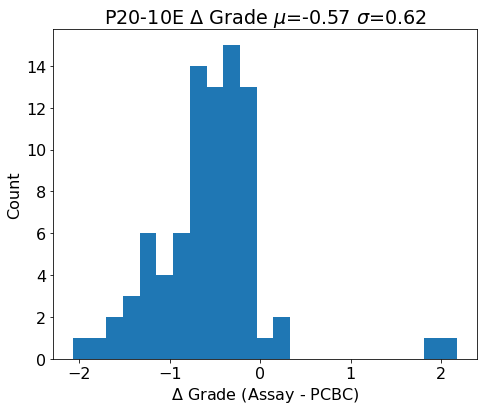

In [23]:
ymin, ymax = ax.get_ylim()
bins = int((ymax - ymin) * 5)

# Create histograms
fig.clear()
ax = fig.add_subplot()

ax.hist(delta_grades, bins=bins)

ax.set_ylabel('Count')
ax.set_xlabel('$\Delta$ Grade (Assay - PCBC)')

desc_stats = pd.Series(delta_grades).describe()
stats[element][id] = {
    'mean': desc_stats['mean'],
    'std': desc_stats['std']
}

ax.set_title(f'{id} $\Delta$ Grade $\mu$={desc_stats["mean"]:0.2f} $\sigma$={desc_stats["std"]:0.2f}')
fig.tight_layout()
fig